In [1]:
''' Check if SD water current data (1-min in airsea files) are the same as ADCP's 1st vertical bin data '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
sys.path.insert(0, path_nhchi)
from convert_dir import convert_dir_to_from

In [2]:
''' Settings ''' 
year = '2023'
SD_num = '1069'
''' Data info '''
path = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/'
fn_airsea = 'data_merge_airsea/airsea-raw-merge-'+year+'-SD'+SD_num+'.nc'
fn_adcp = 'data_merge_adcp/adcp-raw-merge-'+year+'-SD'+SD_num+'.nc'
''' Read SD data '''
ds_airsea = nc.Dataset(path + fn_airsea)
ds_adcp = nc.Dataset(path + fn_adcp)
print(ds_airsea)
print('='*10)
print(ds_adcp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1069 from /Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/delayed_post_mission/sd-1069/
    subtitle: Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(135360)
    variables(dimensions): float64 time(time), float64 UWND_MEAN(time), float64 UWND_STDDEV(time), float64 VWND_MEAN(time), float64 VWND_STDDEV(time), float64 GUST_WND_MEAN(time), float64 GUST_WND_STDDEV(time), float64 WIND_MEASUREMENT_HEIGHT_MEAN(time), float64 TEMP_AIR_MEAN(time), float64 RH_MEAN(time), float64 BARO_PRES_MEAN(time), float64 PAR_AIR_MEAN(time), float64 WAVE_DOMINANT_PERIOD(time), float64 WAVE_SIGNIFICANT_HEIGHT(time), float64 TEMP_DEPTH_HALFMETER_MEAN(time), float64 TEMP_SBE37_MEAN(time), float64 TEMP_SBE37_STDDEV(time), float64 SAL_SBE37_MEAN(time), float64 SAL_SBE37_STDDEV(time),

In [3]:
''' Read variables '''
dtime_airsea = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item) for item in ds_airsea['time'][:]])
cur_spd = np.ma.getdata( ds_airsea['WATER_CURRENT_SPEED_MEAN'][:] )
cur_dir = np.ma.getdata( ds_airsea['WATER_CURRENT_DIRECTION_MEAN'][:] )
u_airsea = cur_spd * np.sin(cur_dir/180*np.pi)
v_airsea = cur_spd * np.cos(cur_dir/180*np.pi)
dtime_adcp = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item) for item in ds_adcp['time'][:]])
u_adcp = np.ma.getdata( ds_adcp['vel_east'][:] )
v_adcp = np.ma.getdata( ds_adcp['vel_north'][:] )
print('airsea time range:',dtime_airsea[0:2],dtime_airsea[-1])
print('adcp time range:',dtime_adcp[0:2],dtime_adcp[-1])

airsea time range: [datetime.datetime(2023, 8, 4, 0, 0) datetime.datetime(2023, 8, 4, 0, 1)] 2023-11-05 23:59:00
adcp time range: [datetime.datetime(2023, 5, 21, 0, 0) datetime.datetime(2023, 5, 21, 0, 5)] 2023-11-04 23:55:00


<Figure size 432x288 with 0 Axes>

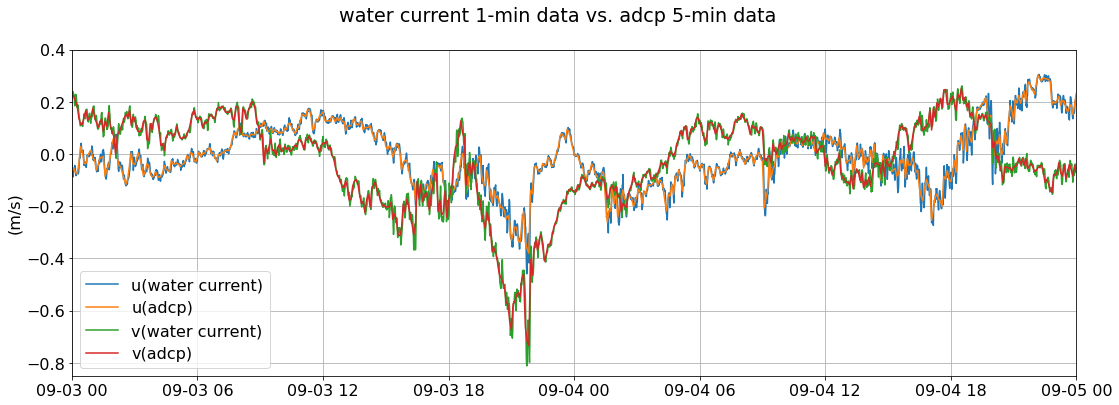

In [53]:
tlim = [datetime.datetime(int(year),9,3),datetime.datetime(int(year),9,5)]
tlim_str = datetime.datetime.strftime(tlim[0],'%Y%m%d-')+datetime.datetime.strftime(tlim[1],'%Y%m%d')
# ylim = [-1.5,1.5]
ylim = [-0.85,0.4]
''' plot timeseries '''
plt.clf()
fig = plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 16})
plt.plot(dtime_airsea, u_airsea,label='u(water current)')
plt.plot(dtime_adcp, u_adcp[:,0],label='u(adcp)')
plt.plot(dtime_airsea, v_airsea,label='v(water current)')
plt.plot(dtime_adcp, v_adcp[:,0],label='v(adcp)')
plt.xlim(tlim)
plt.ylim(ylim)
plt.legend()
plt.grid()
plt.ylabel('(m/s)')
plt.suptitle('water current 1-min data vs. adcp 5-min data')
plt.savefig('check_SD_water_cur-ADCP_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

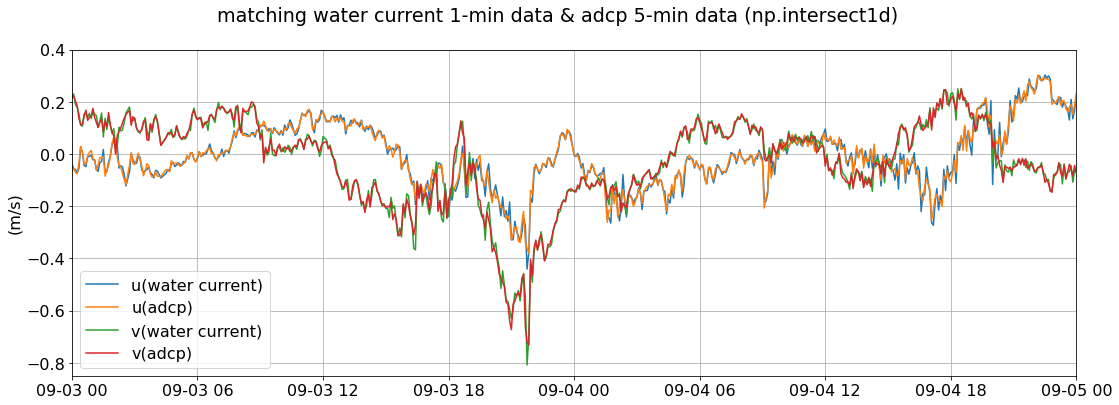

In [ ]:
''' match airsea 1-min to adcp 5-min data '''
dtime_match, i_airsea, i_adcp = np.intersect1d( dtime_airsea, dtime_adcp, assume_unique=True, return_indices=True )
''' plot timeseries '''
plt.clf()
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 6))
plt.plot(dtime_match, u_airsea[i_airsea],label='u(water current)')
plt.plot(dtime_match, u_adcp[i_adcp,0],label='u(adcp)')
plt.plot(dtime_match, v_airsea[i_airsea],label='v(water current)')
plt.plot(dtime_match, v_adcp[i_adcp,0],label='v(adcp)')
plt.xlim(tlim)
plt.ylim(ylim)
plt.legend()
plt.grid()
plt.ylabel('(m/s)')
plt.suptitle('matching water current 1-min data & adcp 5-min data (np.intersect1d)')
plt.savefig('check_SD_water_cur-ADCP_matching-timestamp_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

In [6]:
''' average airsea to 5-min to match adcp '''
u_airsea_5min = np.nan*np.ones( dtime_adcp.shape )
v_airsea_5min = u_airsea_5min.copy()
timestamp_airsea = np.array([item.timestamp() for item in dtime_airsea])
timestamp_adcp = np.array([item.timestamp() for item in dtime_adcp])
dt_max = 2.5*60
cnt = 0
for i, item in enumerate( timestamp_adcp ):
    i_match = np.where( np.abs(timestamp_airsea-item)< dt_max )[0]
    if len(i_match)> 0:
        u_airsea_5min[i] = np.nanmean( u_airsea[i_match] )
        v_airsea_5min[i] = np.nanmean( v_airsea[i_match] )
    # if len(i_match)> 3:
    #     print(datetime.datetime.fromtimestamp(item), [datetime.datetime.fromtimestamp(item) for item in timestamp_airsea[i_match]])
    #     print(item, i_match.shape)
    #     break

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_72943/2625269537.py:11: RuntimeWarning: Mean of empty slice
  u_airsea_5min[i] = np.nanmean( u_airsea[i_match] )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_72943/2625269537.py:12: RuntimeWarning: Mean of empty slice
  v_airsea_5min[i] = np.nanmean( v_airsea[i_match] )


<Figure size 432x288 with 0 Axes>

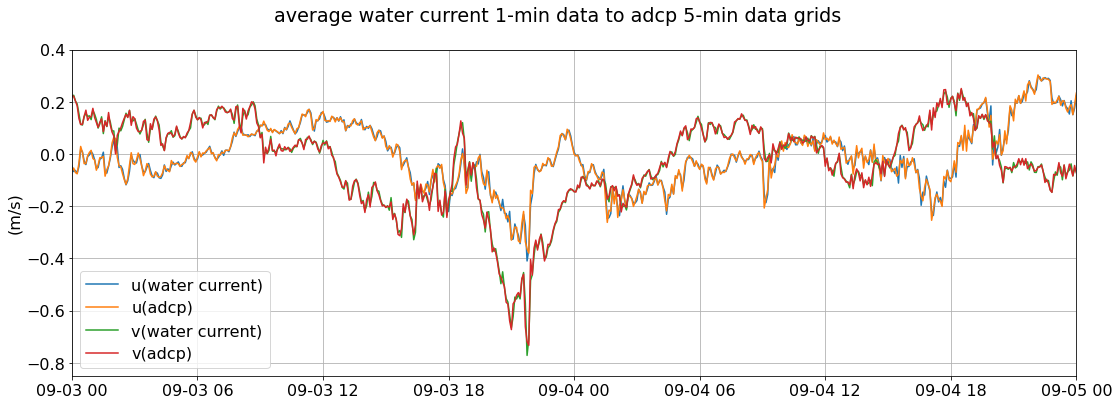

In [56]:
''' plot timeseries '''
plt.clf()
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 6))
plt.plot(dtime_adcp, u_airsea_5min,label='u(water current)')
plt.plot(dtime_adcp, u_adcp[:,0],label='u(adcp)')
plt.plot(dtime_adcp, v_airsea_5min,label='v(water current)')
plt.plot(dtime_adcp, v_adcp[:,0],label='v(adcp)')
plt.xlim(tlim)
plt.ylim(ylim)
plt.legend()
plt.grid()
plt.ylabel('(m/s)')
plt.suptitle('average water current 1-min data to adcp 5-min data grids')
plt.savefig('check_SD_water_cur-ADCP_average-to-adcp-tgrids_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

Text(0.5, 0.98, 'difference between averaged water current 1-min data to adcp 5-min data grids')

<Figure size 432x288 with 0 Axes>

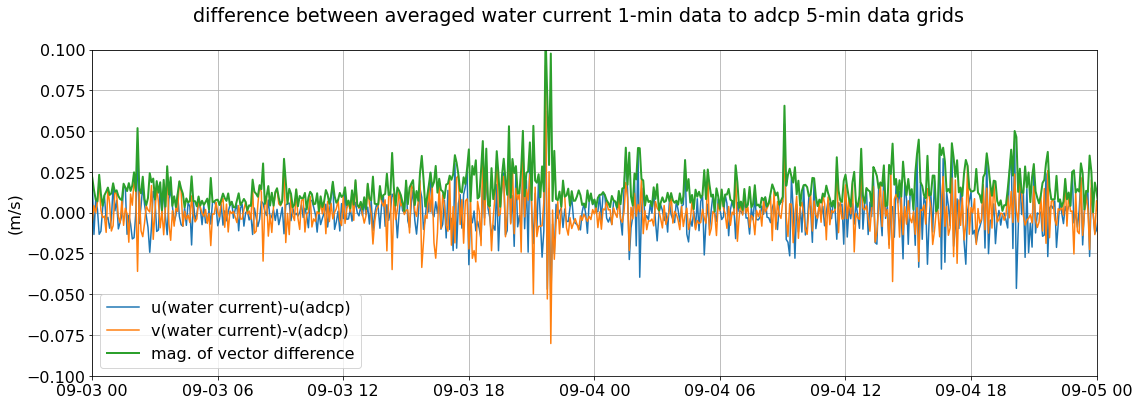

In [ ]:
''' plot difference in timeseries '''
plt.clf()
fig = plt.figure(figsize=(18, 6))
plt.plot(dtime_adcp, u_airsea_5min-u_adcp[:,0],label='u(water current)-u(adcp)')
plt.plot(dtime_adcp, v_airsea_5min-v_adcp[:,0],label='v(water current)-v(adcp)')
plt.plot(dtime_adcp, np.sqrt( np.square(u_airsea_5min-u_adcp[:,0]) + np.square(v_airsea_5min-v_adcp[:,0])),\
         lw=2, label='mag. of vector difference')
plt.xlim(tlim)
plt.ylim([-0.1,0.1])
plt.legend()
plt.grid()
plt.ylabel('(m/s)')
plt.suptitle('difference between averaged water current 1-min data to adcp 5-min data grids')
plt.savefig('check_SD_water_cur-ADCP_diff-average-to-adcp-tgrids_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

0.013011314971423668 0.009850299727517607


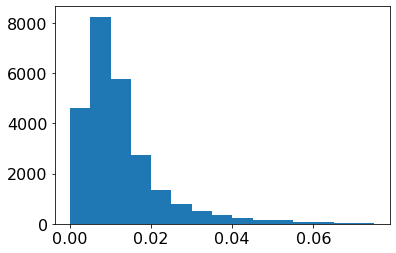

In [62]:
itest = np.where( (dtime_adcp>= tlim[0]) & (dtime_adcp<= tlim[1]) )[0]
test = np.sqrt( np.square(u_airsea_5min-u_adcp[:,0]) + np.square(v_airsea_5min-v_adcp[:,0]))#[itest]
plt.hist( test,np.arange(0,0.08,0.005))
print(np.nanmean(test), np.nanmedian(test))